### BASIC REGRESSION


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
hsi_path = '/content/drive/MyDrive/train_data/train_data/train_data/100.npz'
gt_path = '/content/drive/MyDrive/train_data/train_data/train_gt.csv'
wavelength_path = '/content/drive/MyDrive/train_data/train_data/wavelengths.csv'

In [ ]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

In [ ]:
gt_df[gt_df['sample_index']==1570]

,sample_index,P,K,Mg,pH
1570,1570,47.9,165.0,181.0,6.8


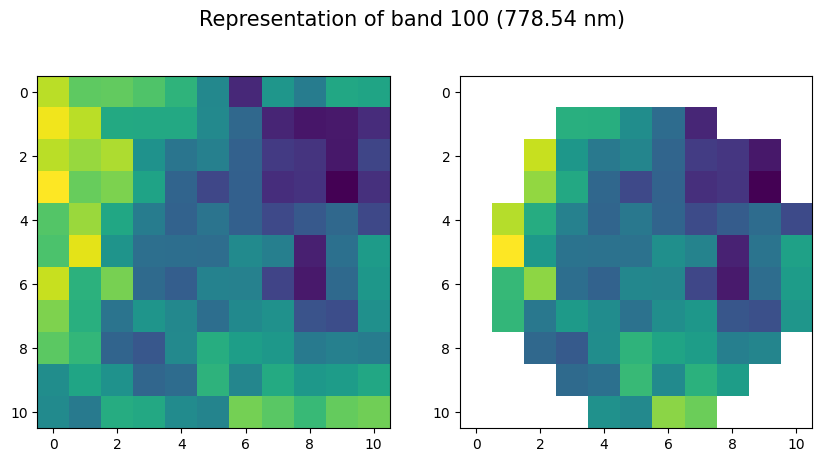

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)
    arr.shape

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

In [ ]:
band_id = 100
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    data = np.ma.MaskedArray(**npz)
    data=data.flatten('F')
    data = data[~data.mask]
    print(data.shape)

(11850,)


In [ ]:
a = np.array([[[1,2,3], [3,4,5],[3,4,5]],[[7,8,9], [10,11,12],[13,14,15]]])
ft=a.flatten('F')
PC=44772*150
pde=np.pad(data,((5,PC-len(data)-5)),'wrap')
pde.shape

(6715800,)

In [ ]:
arr = [1,3,4,5,6,7]

# padding array using 'minimum' mode
pad_arr = np.pad(arr, (0,100), 'wrap')
pad_arr[0:100].shape

(100,)

In [ ]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))

In [ ]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    size=[]
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
            size.append(arr.shape[1]*arr.shape[2])
        arr = filtering(arr)
        data.append(arr)
    return np.array(data),np.array(size)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train,str = load_data("/content/drive/MyDrive/train_data/train_data/train_data")
y_train = load_gt("/content/drive/MyDrive/train_data/train_data/train_gt.csv")
X_test,ste = load_data("/content/drive/MyDrive/test_data/test_data")

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Train data shape: (1732, 150)
Test data shape: (762, 150)


In [ ]:
y_trainx=y_train/np.array([325,625,400, 7.8])
np.max(y_trainx,0)

array([1., 1., 1., 1.])

In [ ]:
np.median(ste)

121.0

In [ ]:
baseline_reg = BaselineRegressor()
baseline_reg = baseline_reg.fit(X_train, y_trainx)
predictions = baseline_reg.predict(X_test)

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission.csv", index_label="sample_index")

In [ ]:
X_test = X_train[1500:]
y_test = y_train[1500:]

X_train_new = X_train[:1500]
y_train_new = y_train[:1500]

# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test)

# Generate baseline values to be used in score computation
baselines = np.mean((y_test - baseline_predictions) ** 2, axis=0)


# Generate random predictions, different from baseline predictions
np.random.seed(0)
predictions = np.zeros_like(y_test)
for column_index in range(predictions.shape[1]):
    class_mean_value = baseline_reg.mean[column_index]
    predictions[:, column_index] = np.random.uniform(low=class_mean_value - class_mean_value * 0.05,
                                                     high=class_mean_value + class_mean_value * 0.05,
                                                     size=len(predictions))

# Calculate MSE for each class
mse = np.mean((y_test - predictions) ** 2, axis=0)

# Calculate the score for each class individually
scores = mse / baselines

# Calculate the final score
final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 0.9896068600445717
Class K score: 1.004900913045855
Class Mg score: 1.0228518828521695
Class pH score: 1.6431314552511207
Final score: 1.1651227777984292


In [ ]:
baselines

array([5.49588849e+02, 3.75637553e+03, 6.44225516e+02, 5.66444647e-02])

In [ ]:
baselines*np.array([325,625,400, 7.8])

array([1.78616376e+05, 2.34773471e+06, 2.57690206e+05, 4.41826824e-01])

In [ ]:
baselines

array([5.49588849e+02, 3.75637553e+03, 6.44225516e+02, 5.66444647e-02])

In [ ]:
mse

array([5.43876895e+02, 3.77478520e+03, 6.58947282e+02, 9.30743017e-02])

In [ ]:
baselines

array([5.49588849e+02, 3.75637553e+03, 6.44225516e+02, 5.66444647e-02])

In [ ]:
from sklearn.decomposition import NMF,FastICA
X = np.random.randint(0, 100, size=(150, 11, 11))
y=np.reshape(X,(150,X.shape[-1]*X.shape[-1]))
#model = NMF(n_components=3, init='random', random_state=0)
model=FastICA(n_components=5, random_state=0)
W = model.fit_transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [ ]:
W.shape

(150, 5)

In [ ]:
X[0]

array([[94, 84, 23, 15, 44, 83, 55, 98, 27, 45, 98],
       [81, 87, 27, 77, 48, 87, 94,  5, 97, 98, 28],
       [65, 68, 85, 72, 33, 99, 48, 99, 89, 69, 65],
       [99, 71,  1,  1, 71, 25, 77, 50, 27, 96, 43],
       [19, 98, 45, 80, 43, 67,  8, 83, 46, 64, 20],
       [96, 98,  5, 85, 24,  2, 71, 75, 28, 95, 65],
       [80, 82, 14, 21, 69, 33,  2, 27, 19, 15, 71],
       [29, 35, 97, 48, 49, 80, 56, 63, 88, 58,  5],
       [51, 61, 83, 17, 45, 96, 62, 22, 97,  9,  5],
       [76, 61, 42, 16, 59, 17, 68, 60, 25, 14, 61],
       [53, 81, 29, 70, 28, 74,  5, 84, 55, 50, 86]])

###KNN and random forest


In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 65.4 MB/s eta 0:00:00


In [ ]:
# GENERAL UTILITIES
import os
from glob import glob
import pandas as pd
from  tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# MODEL DEVELOPMENT DEPENDENCIES
import numpy as np
import pywt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing

In [ ]:
DEBUG = False
AUGMENT_CONSTANT_RF=1
AUGMENT_CONSTANT_KNN=6
LABEL_NAMES = ["P2O5", "K", "Mg", "pH"]
LABEL_MAXS = np.array([325.0, 625.0, 400.0, 7.8])
#Y_BASE_FACT = np.array([121764.2 / 1731.0, 394876.1 / 1731.0, 275875.1 / 1731.0, 11747.67 / 1731.0]) / LABEL_MAXS

COL_IX = [0, 1, 2, 3]

In [ ]:
def load_data(directory: str, gt_file_path: str, is_train=True, augment_constant: int = 0):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
        gt_file_path (str): File path for the ground truth labels (expected CVS file)
        is_train (boolean): Binary flag for setting loader for Train (TRUE) or Test (FALSE)
        augment_constant (int): number of augmentation steps to randomly crop from the larger agricultural fields
    Returns:
        [type]: Tuple of lists composed of raw field (data , mask) pairs,
                and if exists: (augmented data, augmented mask) pairs, and ground truth labels
    """

    datalist = []
    masklist = []
    aug_datalist = []
    aug_masklist = []
    aug_labellist = []

    if is_train:
        labels = load_gt(gt_file_path)

    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )

    if DEBUG:
        all_files = all_files[:100]
        if is_train:
            labels = labels[:100]

    for idx, file_name in tqdm(enumerate(all_files),total=len(all_files), desc="Loading {} data .."
                               .format("training" if is_train else "test")):
       # We load the data into memory as provided in the example notebook of the challenge
        with np.load(file_name) as npz:
            mask = npz["mask"]
            data = npz["data"]
            datalist.append(data)
            masklist.append(mask)

    # for training data we make pre-augmentation by adding some randomly cropped samples
    if is_train:
        for i in range(augment_constant):
            for idx, file_name in tqdm(enumerate(all_files),total=len(all_files), desc="Loading augmentation {} ..".format(i+1)):
                # print(file_name)
                with np.load(file_name) as npz:
                    flag = True
                    mask = npz["mask"]
                    data = npz["data"]
                    ma = np.max(data, keepdims=True)
                    sh = data.shape[1:]
                    for i in range(10):
                        # Repeating 11x11 cropping 10 times does not mean we use all croppings:
                        # as seen in the Flag=False below at the end of the loop,
                        # when we reach at the good crop (not coinciding to the masked area) we stop searching

                        # Randomly cropping the fields with 11x11 size,
                        # and adding some noise to the cropped samples
                        edge = 11
                        x = np.random.randint(sh[0] + 1 - edge)
                        y = np.random.randint(sh[1] + 1 - edge)

                        # get crops having meaningful pixels, not zeros
                        if np.sum(mask[0, x : (x + edge), y : (y + edge)]) > 120:
                            aug_data = (data[:, x : (x + edge), y : (y + edge)]
                                        + np.random.uniform(-0.01, 0.01, (150, edge, edge)) * ma)
                            aug_mask = mask[:, x : (x + edge), y : (y + edge)] | np.random.randint(0, 1, (150, edge, edge))

                            flag = False #break the loop when you have a meaningful crop
                            break

                    # After having  11x11 croped sample, get another crop considering
                    # the minimum edge length: (min_edge,min_edge)
                    if flag:
                        max_edge = np.max(sh)
                        min_edge = np.min(sh)  # AUGMENT BY SHAPE
                        edge = min_edge  # np.random.randint(16, min_edge)
                        x = np.random.randint(sh[0] + 1 - edge)
                        y = np.random.randint(sh[1] + 1 - edge)
                        aug_data = (data[:, x : (x + edge), y : (y + edge)]
                                    + np.random.uniform(-0.001, 0.001, (150, edge, edge)) * ma)
                        aug_mask = mask[:, x : (x + edge), y : (y + edge)] | np.random.randint(0, 1, (150, edge, edge))

                    aug_datalist.append(aug_data)
                    aug_masklist.append(aug_mask)
                    aug_labellist.append(
                        labels[idx, :]
                        + labels[idx, :] * np.random.uniform(-0.001, 0.001, 4)
                    )

    # do pre-augmentation only for training data
    if is_train:
        return (datalist,
                masklist,
                labels,
                aug_datalist,
                aug_masklist,
                np.array(aug_labellist))
    else:
        return datalist, masklist


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values / LABEL_MAXS  # normalize ground-truth between 0-1

    return labels

In [ ]:
import os
import shutil
from math import ceil
from pathlib import Path

# Define paths
original_train_path = "/content/drive/MyDrive/train_data/train_data/train_data"
original_test_path = "/content/drive/MyDrive/test_data/test_data"
new_train_path = "/content/train_data"
new_test_path = "/content/test_data"

# Create new directories if they don't exist
os.makedirs(new_train_path, exist_ok=True)
os.makedirs(new_test_path, exist_ok=True)

# Function to copy half the files from source to destination
def copy_half_files(src_path, dest_path):
    # List all files in the source directory
    files = os.listdir(src_path)
    # Sort files for consistency
    files.sort()
    # Get half the files
    num_files_to_copy = ceil(len(files) / 10)
    selected_files = files[:num_files_to_copy]

    # Copy selected files to the destination
    for file in selected_files:
        shutil.copy(os.path.join(src_path, file), os.path.join(dest_path, file))
    print(f"Copied {num_files_to_copy} files from {src_path} to {dest_path}")

# Copy half of the files from the original folders to the new folders
copy_half_files(original_train_path, new_train_path)
copy_half_files(original_test_path, new_test_path)


Copied 174 files from /content/drive/MyDrive/train_data/train_data/train_data to /content/train_data
Copied 77 files from /content/drive/MyDrive/test_data/test_data to /content/test_data


In [ ]:
import pandas as pd
import os

# Define paths
train_data_folder = "/content/train_data"
original_csv_path = "/content/drive/MyDrive/train_data/train_data/train_gt.csv"
new_csv_path = "/content/new_train_gt.csv"  # Path for the new CSV

# Get list of file names (without extension) in the train_data folder
file_names = {int(f.split('.')[0]) for f in os.listdir(train_data_folder) if f.endswith('.npz')}

# Load the original CSV
df = pd.read_csv(original_csv_path)

# Filter the DataFrame to only include rows where 'sample_index' exists in the file names
filtered_df = df[df['sample_index'].isin(file_names)]

# Save the filtered DataFrame to a new CSV
filtered_df.to_csv(new_csv_path, index=False)

print(f"New CSV file created at: {new_csv_path}")


New CSV file created at: /content/new_train_gt.csv


In [ ]:
train_data_dir = "/content/train_data"
test_data_dir = "/content/test_data"
gt_data_path = "/content/new_train_gt.csv"

# Loading training raw data
X_train, M_train, y_train, X_aug_train, M_aug_train, y_aug_train = load_data(train_data_dir,
                                                                             gt_data_path,
                                                                             is_train=True,
                                                                             augment_constant=AUGMENT_CONSTANT_KNN)
# Loading test raw data
X_test, M_test = load_data(test_data_dir,
                           gt_file_path=None,
                           is_train=False)

print(f"Train data size: {len(X_train)}")
print(f"Train aug data size: {len(X_aug_train)}")
print(f"Test data size: {len(X_test)}")

Loading training data ..:   0%|          | 0/173 [00:00<?, ?it/s]

Loading augmentation 1 ..:   0%|          | 0/173 [00:00<?, ?it/s]

Loading augmentation 2 ..:   0%|          | 0/173 [00:00<?, ?it/s]

Loading augmentation 3 ..:   0%|          | 0/173 [00:00<?, ?it/s]

Loading augmentation 4 ..:   0%|          | 0/173 [00:00<?, ?it/s]

Loading augmentation 5 ..:   0%|          | 0/173 [00:00<?, ?it/s]

Loading augmentation 6 ..:   0%|          | 0/173 [00:00<?, ?it/s]

Loading test data ..:   0%|          | 0/77 [00:00<?, ?it/s]

Train data size: 173
Train aug data size: 1038
Test data size: 77


In [ ]:
def preprocess(data_list, mask_list, is_for_KNN=False):
    """Extract high-level features from the raw field data.

    Args:
        data_list: Directory to either train or test set
        mask_list: File path for the ground truth labels (expected CVS file)
        is_for_KNN: Binary flag for determining if the features are generated for KNN (TRUE) or Random Forest (FALSE)
    Returns:
        [type]: Tuple of lists composed of (features , field size) pairs for each field,
                where field size will be used performance analysis.
    """

    def _shape_pad(data):
        # This sub-function makes padding to have square fields sizes.
        # Not mandatory but eliminates the risk of calculation error in singular value decomposition,
        # padding by warping also improves the performance slightly.
        max_edge = np.max(image.shape[1:])
        shape = (max_edge, max_edge)
        padded = np.pad(data,((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))),"wrap")
        return padded

    filtering = SpectralCurveFiltering()
    w1 = pywt.Wavelet("sym3")
    w2 = pywt.Wavelet("dmey")

    processed_data = []
    average_edge = []

    for idx, (data, mask) in enumerate(
        tqdm(
            zip(data_list, mask_list),
            total=len(data_list),
            position=0,
            leave=True,
            desc="INFO: Preprocessing data ...",
        )
    ):
        data = data / 2210   # max-max=5419 mean-max=2210
        m = 1 - mask.astype(int)
        image = data * m

        average_edge.append((image.shape[1] + image.shape[2]) / 2)
        image = _shape_pad(image)

        s = np.linalg.svd(image, full_matrices=False, compute_uv=False)
        s0 = s[:, 0]
        s1 = s[:, 1]
        s2 = s[:, 2]
        s3 = s[:, 3]
        s4 = s[:, 4]
        dXds1 = s0 / (s1 + np.finfo(float).eps)


        data = np.ma.MaskedArray(data, mask)
        arr = filtering(data)

        cA0, cD0 = pywt.dwt(arr, wavelet=w2, mode="constant")
        cAx, cDx = pywt.dwt(cA0[12:92], wavelet=w2, mode="constant")
        cAy, cDy = pywt.dwt(cAx[15:55], wavelet=w2, mode="constant")
        cAz, cDz = pywt.dwt(cAy[15:35], wavelet=w2, mode="constant")
        cAw2 = np.concatenate((cA0[12:92], cAx[15:55], cAy[15:35], cAz[15:25]), -1)
        cDw2 = np.concatenate((cD0[12:92], cDx[15:55], cDy[15:35], cDz[15:25]), -1)

        cA0, cD0 = pywt.dwt(arr, wavelet=w1, mode="constant")
        cAx, cDx = pywt.dwt(cA0[1:-1], wavelet=w1, mode="constant")
        cAy, cDy = pywt.dwt(cAx[1:-1], wavelet=w1, mode="constant")
        cAz, cDz = pywt.dwt(cAy[1:-1], wavelet=w1, mode="constant")
        cAw1 = np.concatenate((cA0, cAx, cAy, cAz), -1)
        cDw1 = np.concatenate((cD0, cDx, cDy, cDz), -1)

        dXdl = np.gradient(arr, axis=0)
        d2Xdl2 = np.gradient(dXdl, axis=0)
        d3Xdl3 = np.gradient(d2Xdl2, axis=0)


        fft = np.fft.fft(arr)
        real = np.real(fft)
        imag = np.imag(fft)
        ffts = np.fft.fft(s0)
        reals = np.real(ffts)
        imags = np.imag(ffts)

        # The best Feature combination for Random Forest based regression
        out_rf = np.concatenate(
            [
                arr,
                dXdl,
                d2Xdl2,
                d3Xdl3,
                dXds1,
                s0,
                s1,
                s2,
                s3,
                s4,
                real,
                imag,
                reals,
                imags,
                cAw1,
                cAw2,
            ],
            -1,
        )

        # The best Feature combination for KNN based regression
        out_knn = np.concatenate(
            [
                arr,
                dXdl,
                d2Xdl2,
                d3Xdl3,
                s0,
                s1,
                s2,
                s3,
                s4,
                real,
                imag,

            ],
            -1,
        )


        if is_for_KNN:
            processed_data.append(out_knn)
        else:
            processed_data.append(out_rf)

    return np.array(processed_data), np.array(average_edge)



class SpectralCurveFiltering: # Default class provided by the challenge organizers
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function=np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))

In [ ]:
# preprocessed data for random forest traninig and testing
X_tr_processed_RF, avg_edge_train = preprocess(X_train, M_train, is_for_KNN=False)
X_aug_processed_RF, avg_edge_train_aug_RF = preprocess(X_aug_train[:len(X_train)*AUGMENT_CONSTANT_RF], M_aug_train[:len(X_train)*AUGMENT_CONSTANT_RF], is_for_KNN=False)
X_te_processed_RF, avg_edge_test = preprocess(X_test, M_test, is_for_KNN=False)

# preprocessed data for KNN traninig and testing
X_tr_processed_KNN, avg_edge_train = preprocess(X_train, M_train, is_for_KNN=True)
X_aug_processed_KNN, avg_edge_train_aug_KNN = preprocess(X_aug_train, M_aug_train,is_for_KNN=True)
X_te_processed_KNN, avg_edge_test = preprocess(X_test, M_test, is_for_KNN=True)

INFO: Preprocessing data ...:   0%|          | 0/173 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/173 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/77 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/173 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/1038 [00:00<?, ?it/s]

INFO: Preprocessing data ...:   0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """

    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)

In [ ]:
# Select set of labels

y_train_col = y_train[:, COL_IX]
y_aug_train_col = y_aug_train[:len(y_train_col)*AUGMENT_CONSTANT_RF, COL_IX]

In [ ]:
# 5-fold cross validation for training.

kfold = KFold(shuffle=True, random_state=2022)
kfold.get_n_splits(X_aug_train, y_aug_train_col)

5

In [ ]:
random_forest_models = []
baseline_regressors = []

y_hat_bl = []
y_hat_rf = []
y_v_list_rf = []
edge_v_list_rf = []

for idx, (ix_train, ix_valid) in enumerate(kfold.split(np.arange(0, len(y_train)), avg_edge_train.astype(int))):
    print("CROSS VALIDATION STEP: {}".format(idx))

    # Merge original data with the augmented data on training set
    X_t = np.concatenate((X_tr_processed_RF[ix_train], X_aug_processed_RF[ix_train]), axis=0)
    y_t = np.concatenate((y_train_col[ix_train], y_aug_train_col[ix_train]), axis=0)

    # Filter out Validation set
    X_v = X_tr_processed_RF[ix_valid]
    y_v =y_train_col[ix_valid]
    y_v_list_rf.append(y_v)

    #Field edge sizes will be used for performance analysis later
    edge = avg_edge_train[ix_valid]
    edge_v_list_rf.append(edge)

    # baseline fiting
    baseline = BaselineRegressor()
    baseline.fit(X_t, y_t)
    baseline_regressors.append(baseline)

    # baseline predictions
    y_b = baseline.predict(X_v)
    y_hat_bl.append(y_b)

    # random forest fitting
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    model.fit(X_t, y_t)
    random_forest_models.append(model)

    # random forest predictions
    y_hat = model.predict(X_v)
    y_hat_rf.append(y_hat)

    print('Prediction score: {}'.format(model.score(X_v, y_v)))


CROSS VALIDATION STEP: 0
Prediction score: 0.3908545968011422
CROSS VALIDATION STEP: 1
Prediction score: 0.3386348874166726
CROSS VALIDATION STEP: 2
Prediction score: 0.43142296147927944
CROSS VALIDATION STEP: 3
Prediction score: 0.3333232072386696
CROSS VALIDATION STEP: 4
Prediction score: 0.4245903987518081


In [ ]:
scores = 0
for y_hat, y_b, y_v, y_e in zip(y_hat_rf, y_hat_bl, y_v_list_rf, edge_v_list_rf):
    score = 0
    for i in COL_IX:
        print('\n')
        print("Result for parameter: ", LABEL_NAMES[i])
        mse_rf = mean_squared_error(y_v[:, i] * LABEL_MAXS[i], y_hat[:, i] * LABEL_MAXS[i])
        mse_bl = mean_squared_error(y_v[:, i] * LABEL_MAXS[i], y_b[:, i] * LABEL_MAXS[i])
        score += mse_rf / mse_bl
        print(f"Baseline MSE:      {mse_bl:.2f}")
        print(f"Random Forest MSE: {mse_rf:.2f} ({1e2*(mse_rf - mse_bl)/mse_bl:+.2f} %)")


    print('\n')
    print("CV Evaluation score:", score / 4)

    scores += score

print('\n')
print("OVERALL CV EVALUATION SCORE:", scores / 20)

In [ ]:
scores = 0
out_table = []


for y_h, y_b, y_v, y_e in zip(y_hat_rf, y_hat_bl, y_v_list_rf, edge_v_list_rf):
    mse_rf = np.square(
        np.subtract(y_h * LABEL_MAXS, y_v * LABEL_MAXS)
    )
    mse_bl = np.square(
        np.subtract(y_v * LABEL_MAXS, y_b * LABEL_MAXS)
    )
    row = np.zeros((len(y_h), 9))
    row[:, 8] = y_e
    row[:, 0:4] = mse_rf
    row[:, 4:8] = mse_bl
    out_table.append(row)

In [ ]:
x = np.concatenate(out_table, 0)
df = pd.DataFrame(
    x,
    columns=["P2O5", "K", "Mg", "pH", "P2O5_avg", "K_avg", "Mg_avg", "pH_avg", "Edge"],
)
df.head(10)
_, bin_edge = np.histogram(df.Edge.values, bins=4)

# We have determined those bin edges after looking at the field size distribuiton
bin_edge = [0, 11, 40, 50, 100, 110, 120, 130, 210]
bin_edge_labels = [
    "0-11",
    "11-40",
    "40-50",
    "50-100",
    "100-110",
    "110-120",
    "120-130",
    "130+",
]
mse_per_edge = np.zeros((len(bin_edge) - 1, 6), dtype=object)

for i in range(1, len(bin_edge)):
    d_temp = df[(df.Edge <= bin_edge[i]) & (df.Edge > bin_edge[i - 1])]
    mse_per_edge[i - 1, 0] = np.mean(d_temp.P2O5.values) / np.mean(
        d_temp.P2O5_avg.values
    )
    mse_per_edge[i - 1, 1] = np.mean(d_temp.K.values) / np.mean(d_temp.K_avg.values)
    mse_per_edge[i - 1, 2] = np.mean(d_temp.Mg.values) / np.mean(d_temp.Mg_avg.values)
    mse_per_edge[i - 1, 3] = np.mean(d_temp.pH.values) / np.mean(d_temp.pH_avg.values)
    mse_per_edge[i - 1, 5] = len(d_temp)
    mse_per_edge[i - 1, 4] = bin_edge_labels[i - 1]

In [ ]:
d_out = pd.DataFrame(mse_per_edge, columns=["P2O5", "K", "Mg", "pH", "Edge", "Len"])
d_out

In [ ]:
random_forests = []
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)

X_t = np.concatenate((X_tr_processed_RF, X_aug_processed_RF), axis=0)
y_t = np.concatenate((y_train_col, y_aug_train_col), axis=0)

model.fit(X_t, y_t)

random_forests.append(model)

In [ ]:
predictions_large = []

#make predictions on multiple models if there are more than 1 model and later mean the results over them
for rf in random_forests:
    pp = rf.predict(X_te_processed_RF[avg_edge_test>11, :]) #X_te_processed_RF[432:, :]
    predictions_large.append(pp)

predictions_large = np.asarray(predictions_large)
predictions_large = np.mean(predictions_large, axis=0)
predictions_large = predictions_large * LABEL_MAXS # predictions were in the range of [0,1] so that we neeed to scale them back.

submission_df = pd.DataFrame(data=predictions_large, columns=["P", "K", "Mg", "pH"])
submission_df.to_csv("submission_large.csv", index_label="sample_index")
submission_df

In [ ]:
X_tr_processed_normalized_small = np.array(X_tr_processed_KNN[0:650, :], copy=True) #avg_edge_train<=11
X_aug_processed_normalized_large = np.array(X_aug_processed_KNN[650:1732, :], copy=True) #avg_edge_train>11
X_te_processed_normalized = np.array(X_te_processed_KNN, copy=True)

for i in range(1, AUGMENT_CONSTANT_KNN):
    X_aug_processed_normalized_large = np.concatenate(
        [X_aug_processed_normalized_large,
         X_aug_processed_KNN[650 + (i * 1732) : i * 1732 + 1732, :]],0,)

y_train_small = y_train[0:650, :]
avg_edge_train_small= avg_edge_train[0:650]
y_aug_train_large = y_aug_train[650:1732, :]

for i in range(1, AUGMENT_CONSTANT_KNN):
    y_aug_train_large = np.concatenate(
        [y_aug_train_large, y_aug_train[650 + (i * 1732) : (i * 1732) + 1732, :]], 0)

In [ ]:
# Feature normalization
for i in range(int(X_tr_processed_normalized_small.shape[-1] / 150)):
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_tr_processed_normalized_small[:, 150 * i : 150 * i + 150])

    X_tr_processed_normalized_small[:, 150 * i : 150 * i + 150] = scaler.transform(
        X_tr_processed_normalized_small[:, 150 * i : 150 * i + 150])

    X_aug_processed_normalized_large[:, 150 * i : 150 * i + 150] = scaler.transform(
        X_aug_processed_normalized_large[:, 150 * i : 150 * i + 150])

    X_te_processed_normalized[:, 150 * i : 150 * i + 150] = scaler.transform(
        X_te_processed_normalized[:, 150 * i : 150 * i + 150])

In [ ]:
# Select set of labels

y_train_small_col = y_train_small[:, COL_IX]
y_aug_train_large_col = y_aug_train_large[:, COL_IX]

In [ ]:
# 5-fold cross validation for training.

kfold = KFold(shuffle=True)
kfold.get_n_splits(X_tr_processed_normalized_small, y_train_small)

In [ ]:
#Train the model for small fields only


KNN_models = []
baseline_regressors = []

y_hat_bl = []
y_hat_knn = []
y_v_list_knn = []
edge_v_list_knn = []

for idx, (ix_train, ix_valid) in enumerate(
    kfold.split(np.arange(0, len(y_train_small)))
):
    print("CROSS VALIDATION STEP: ".format(str(idx)))

    X_t = X_tr_processed_normalized_small[ix_train]
    y_t = y_train_small_col[ix_train]

    X_t = np.concatenate((X_tr_processed_normalized_small[ix_train], X_aug_processed_normalized_large), axis=0)
    y_t = np.concatenate((y_train_small_col[ix_train], y_aug_train_large_col), axis=0)

    X_v = X_tr_processed_normalized_small[ix_valid]
    y_v = y_train_small_col[ix_valid]
    y_v_list_knn.append(y_v)


    edge = avg_edge_train_small[ix_valid]
    edge_v_list_knn.append(edge)

    # baseline training
    baseline = BaselineRegressor()
    baseline.fit(X_t, y_t)
    baseline_regressors.append(baseline)

    # baseline predictions
    y_b = baseline.predict(X_v)
    y_hat_bl.append(y_b)


    # KNN training
    model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=170, weights="distance"))
    model.fit(X_t, y_t)
    KNN_models.append(model)


    # KNN predictions
    y_hat = model.predict(X_v)
    y_hat_knn.append(y_hat)


    print('Prediction score: {}'.format(model.score(X_v, y_v)))



scores = 0
for y_hat, y_b, y_v, y_e in zip(y_hat_knn, y_hat_bl, y_v_list_knn, edge_v_list_knn):
    score = 0
    for i in COL_IX:
        print('\n')
        print("Result for parameter: ", LABEL_NAMES[i])
        mse_knn = mean_squared_error(y_v[:, i] * LABEL_MAXS[i], y_hat[:, i] * LABEL_MAXS[i])
        mse_bl = mean_squared_error(y_v[:, i] * LABEL_MAXS[i], y_b[:, i] * LABEL_MAXS[i])
        score += mse_knn / mse_bl
        print(f"Baseline MSE:      {mse_bl:.2f}")
        print(f"Random Forest MSE: {mse_knn:.2f} ({1e2*(mse_knn - mse_bl)/mse_bl:+.2f} %)")


    print('\n')
    print("CV Evaluation score:", score / 4)

    scores += score

print('\n')
print("OVERALL CV EVALUATION SCORE:", scores / 20)

In [ ]:
scores = 0
out_table = []

for y_h, y_b, y_v, y_e in zip(y_hat_knn, y_hat_bl, y_v_list_knn, edge_v_list_knn):
    mse_knn = np.square(np.subtract(y_h * LABEL_MAXS, y_v * LABEL_MAXS))
    mse_bl = np.square(np.subtract(y_v * LABEL_MAXS, y_b * LABEL_MAXS))
    row = np.zeros((len(y_h), 9))
    row[:, 8] = y_e
    row[:, 0:4] = mse_knn
    row[:, 4:8] = mse_bl
    out_table.append(row)

In [ ]:
x = np.concatenate(out_table, 0)
df = pd.DataFrame(
    x,
    columns=["P2O5", "K", "Mg", "pH", "P2O5_avg", "K_avg", "Mg_avg", "pH_avg", "Edge"],
)
df.head(10)
_, bin_edge = np.histogram(df.Edge.values, bins=4)
# print(bin_edge)
bin_edge = [0, 11, 40, 50, 100, 110, 120, 130, 210]
bin_edge_labels = [
    "0-11",
    "11-40",
    "40-50",
    "50-100",
    "100-110",
    "110-120",
    "120-130",
    "130+",
]
mse_per_edge = np.zeros((len(bin_edge) - 1, 6), dtype=object)

for i in range(1, len(bin_edge)):
    d_temp = df[(df.Edge <= bin_edge[i]) & (df.Edge > bin_edge[i - 1])]
    mse_per_edge[i - 1, 0] = np.mean(d_temp.P2O5.values) / np.mean(
        d_temp.P2O5_avg.values
    )
    mse_per_edge[i - 1, 1] = np.mean(d_temp.K.values) / np.mean(d_temp.K_avg.values)
    mse_per_edge[i - 1, 2] = np.mean(d_temp.Mg.values) / np.mean(d_temp.Mg_avg.values)
    mse_per_edge[i - 1, 3] = np.mean(d_temp.pH.values) / np.mean(d_temp.pH_avg.values)
    mse_per_edge[i - 1, 5] = len(d_temp)
    mse_per_edge[i - 1, 4] = bin_edge_labels[i - 1]

In [ ]:
d_out = pd.DataFrame(mse_per_edge, columns=["P2O5", "K", "Mg", "pH", "Edge", "Len"])
d_out

In [ ]:
#Generate the submission for the small fields

predictions_small = []
counter = 0
for knn in KNN_models:
    pp = knn.predict(X_te_processed_normalized[avg_edge_test<=11, :])
    predictions_small.append(pp)

predictions_small = np.asarray(predictions_small)


predictions_small = np.mean(predictions_small, axis=0)
predictions_small = predictions_small * LABEL_MAXS # predictions were in the range of [0,1] so that we neeed to scale them back.

submission_df = pd.DataFrame(data=predictions_small, columns=["P", "K", "Mg", "pH"])
submission_df.to_csv("submission_small_fields.csv", index_label="sample_index")
submission_df

In [ ]:
submission_df = pd.DataFrame(data=np.concatenate([predictions_small , predictions_large],axis=0), columns=["P", "K", "Mg", "pH"])
submission_df.to_csv("submission_hybrid.csv", index_label="sample_index")
submission_df

In [ ]:
FIG_SIZE=(12,10)
FONT_SIZE=24

density_param = {"density": False}
figs, axs = plt.subplots(2, 2, figsize=FIG_SIZE)

# for i in range(len(cols)):
p1 = sns.distplot(
    y_train[:, 0] * LABEL_MAXS[0],
    kde=True,
    norm_hist=True,
    bins=50,
    color="C{}".format(0),
    ax=axs[0, 0],
)
axs[0, 0].grid(color="C{}".format(0), linestyle="-.", linewidth=0.5)
axs[0, 0].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axs[0, 0].set_xlabel("Target Value",fontsize=FONT_SIZE-2)
axs[0, 0].set_title("Target Distribution for {}".format(LABEL_NAMES[0]),fontsize=FONT_SIZE)

p1 = sns.distplot(
    y_train[:, 1] * LABEL_MAXS[1],
    kde=True,
    norm_hist=True,
    bins=50,
    color="C{}".format(1),
    ax=axs[0, 1],
)
axs[0, 1].grid(color="C{}".format(1), linestyle="-.", linewidth=0.5)
axs[0, 1].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axs[0, 1].set_xlabel("Target Value",fontsize=FONT_SIZE-2)
axs[0, 1].set_title("Target Distribution for {}".format(LABEL_NAMES[1]),fontsize=FONT_SIZE)


p1 = sns.distplot(
    y_train[:, 2] * LABEL_MAXS[2],
    kde=True,
    norm_hist=True,
    bins=50,
    color="C{}".format(2),
    ax=axs[1, 0],
)
axs[1, 0].grid(color="C{}".format(2), linestyle="-.", linewidth=0.5)
axs[1, 0].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axs[1, 0].set_xlabel("Target Value",fontsize=FONT_SIZE-2)
axs[1, 0].set_title("Target Distribution for {}".format(LABEL_NAMES[2]),fontsize=FONT_SIZE)

p1 = sns.distplot(
    y_train[:, 3] * LABEL_MAXS[3],
    kde=True,
    norm_hist=True,
    bins=50,
    color="C{}".format(3),
    ax=axs[1, 1],
)
axs[1, 1].grid(color="C{}".format(3), linestyle="-.", linewidth=0.5)
axs[1, 1].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axs[1, 1].set_xlabel("Target Value",fontsize=FONT_SIZE-2)
axs[1, 1].set_title("Target Distribution for {}".format(LABEL_NAMES[3]),fontsize=FONT_SIZE)


figs.tight_layout()
#figs.savefig("target_distribution.jpg")
plt.savefig('target_distribution.png')

In [ ]:
FIG_SIZE=(12,5)
FONT_SIZE=24

density_param = {"density": True}
figs, axss = plt.subplots(1, 2, figsize=FIG_SIZE)
# axss[0].hist(avg_edge_train, bins=50, **density_param)
p0 = sns.distplot(
    avg_edge_train,
    kde=True,
    norm_hist=False,
    bins=25,
    color="darkgoldenrod",
    ax=axss[0],
)
axss[0].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axss[0].set_xlabel("Average Edge Pixel",fontsize=FONT_SIZE-2)
axss[0].set_title("Field Size Distribution for Training",fontsize=FONT_SIZE)
axss[0].grid(color="darkgoldenrod", linestyle="-.", linewidth=0.5)

p1 = sns.distplot(
    avg_edge_test, kde=True, norm_hist=False, bins=25, color="goldenrod", ax=axss[1]
)
axss[1].set_ylabel("Density Distribution [%]",fontsize=FONT_SIZE-2)
axss[1].set_xlabel("Average Edge Pixel Length",fontsize=FONT_SIZE-2)
axss[1].set_title("Field Size Distribution for Test",fontsize=FONT_SIZE)
axss[1].grid(color="goldenrod", linestyle="-.", linewidth=0.5)

figs.tight_layout()
plt.savefig("field_distribution.png")

In [ ]:
feats = {}
#arr, dXdl, d2Xdl2, d3Xdl3, dXds1, s0, s1, s2, s3, s4, reals, imags, cDw2, cAw2
for idx,rf in enumerate(random_forests):
    if idx==0: importances = rf.feature_importances_
    else: importances += rf.feature_importances_

imps=[]
for i in range(16):
    #if i==10 or i==11: continue
    imps.append(importances[150*i:150*(i+1)])

imps=np.array(imps)
imp_sum=np.sum(np.array(imps),1)
imp_sum=np.expand_dims(imp_sum/np.sum(imp_sum),1)



feature_names = ['Average reflections over channels',
                 '1st derivative of avg. reflections',
                 '2nd derivative of avg. reflections',
                 '3rd derivative of avg. reflections',
                 'Ratio of 1st & 2nd diagonals of SVD',
                 '1st principal at diagonal value of SVD',
                 '2nd principal at diagonal value of SVD',
                 '3rd principal at diagonal value of SVD',
                 '4th principal at diagonal value of SVD',
                 '5th principal at diagonal value of SVD',
                 'Real part of FFT over average reflections',
                 'Imag part of FFT over average reflections',
                 'Real part of FFT over 1st & 2nd diag. of SVD',
                 'Imag part of FFT over 1st & 2nd diag. of SVD',
                 'Approximation coefficients of wavelet transform',
                 'Detail coefficients of wavelet transform']

names=pd.DataFrame(np.expand_dims(np.array(feature_names),1),columns=['name'])
feats=np.concatenate([imp_sum, imps],1)

wavelength_path = '/p/project/hai_cons_ee/kuzu/ai4eo-hyperview/hyperview/keras/train_data/wavelengths.csv'
wavelength_df = pd.read_csv(wavelength_path)
columns=['weight', *wavelength_df['wavelength'].values]

feats = pd.DataFrame(feats,columns=columns)

w_out = pd.concat([names,feats],axis=1)
w_out.head()
w_out=w_out.sort_values(by='weight', ascending=True)

In [ ]:
FIG_SIZE=(12,6)
FONT_SIZE=18

w_out[['name', 'weight']].plot(kind="barh",grid=True,x="name",figsize=(9,4),color='g')
plt.rcParams['axes.facecolor'] = 'none'
plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Feature Weights for Random Forest",fontsize=FONT_SIZE)
plt.xlabel("Weights Ordered by Importance",fontsize=FONT_SIZE-2)
plt.ylabel("Feature Names",fontsize=FONT_SIZE-2)
plt.tight_layout()
plt.savefig('feature_weights.png')

In [ ]:
#for y_hat, y_b, y_v, y_e in zip(y_hat_rf_2,y_hat_bl_2, y_v_list_2,edge_v_list_2):
yh1=np.concatenate(y_hat_rf,0)
yv1=np.concatenate(y_v_list_rf,0)
ye1=np.concatenate(edge_v_list_rf,0)
yh2=np.concatenate(y_hat_knn,0)
yv2=np.concatenate(y_v_list_knn,0)
ye2=np.concatenate(edge_v_list_knn,0)

yh1=yh1[ye1 > 11]
yv1=yv1[ye1 > 11]
yh2=yh2[ye2 <= 11]
yv2=yv2[ye2 <= 11]

FIG_SIZE=(12,12)
FONT_SIZE=24

yv=np.concatenate([yv1,yv2],0)
yh=np.concatenate([yh1,yh2],0)
fig, axs = plt.subplots(2, 2, figsize=FIG_SIZE)

IDX=0
#axs[0,0].set_aspect('equal')
img = axs[0,0].hexbin(yv[:, IDX]*LABEL_MAXS[IDX], yh[:, IDX]*LABEL_MAXS[IDX], cmap='viridis', mincnt=1)
axs[0,0].plot(np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])),np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])), 'r--')
axs[0,0].set_xlabel('True ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)
axs[0,0].set_ylabel('Predicted ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)

IDX=1
#axs[0,1].set_aspect('equal')
img = axs[0,1].hexbin(yv[:, IDX]*LABEL_MAXS[IDX], yh[:, IDX]*LABEL_MAXS[IDX], cmap='viridis', mincnt=1)
axs[0,1].plot(np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])),np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])), 'r--')
axs[0,1].set_xlabel('True ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)
axs[0,1].set_ylabel('Predicted ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)

IDX=2
#axs[1,0].set_aspect('equal')
img = axs[1,0].hexbin(yv[:, IDX]*LABEL_MAXS[IDX], yh[:, IDX]*LABEL_MAXS[IDX], cmap='viridis', mincnt=1)
axs[1,0].plot(np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])),np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])), 'r--')
axs[1,0].set_xlabel('True ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)
axs[1,0].set_ylabel('Predicted ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)

IDX=3
#axs[1,1].set_aspect('equal')
img = axs[1,1].hexbin(yv[:, IDX]*LABEL_MAXS[IDX], yh[:, IDX]*LABEL_MAXS[IDX], cmap='viridis', mincnt=1)
axs[1,1].plot(np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])),np.arange(np.min(yv[:, IDX]*LABEL_MAXS[IDX]), np.max(yv[:, IDX]*LABEL_MAXS[IDX])), 'r--')
axs[1,1].set_xlabel('True ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)
axs[1,1].set_ylabel('Predicted ' + LABEL_NAMES[IDX],fontsize=FONT_SIZE)




plt.colorbar(img, ax=ax)
plt.tight_layout()
plt.savefig('out_prediction.png')

In [ ]:
X_tr_processed_RF_normalized = np.array(X_tr_processed_RF, copy=True)
for i in range(int(X_tr_processed_RF.shape[-1] / 150)):
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_tr_processed_RF[:, 150 * i : 150 * i + 150])

    X_tr_processed_RF_normalized[:, 150 * i : 150 * i + 150] = scaler.transform(
        X_tr_processed_RF[:, 150 * i : 150 * i + 150])

FIG_SIZE=(6,6)
FONT_SIZE=20

IDX=np.array([120,419,454,644])
wavelength_path = '/p/project/hai_cons_ee/kuzu/ai4eo-hyperview/hyperview/keras/train_data/wavelengths.csv'
wavelength_df = pd.read_csv(wavelength_path)

fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,150:300], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('1st Derivatives of Avg. Reflectance',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('1st_derivative.png')


fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,300:450], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('2nd Derivatives of Avg. Reflectance',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('2nd_derivative.png')




fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,600:750], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('s1/s2 Ratio for Each Channel',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('s1_s2_ratio.png')



fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,750:900], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('1st Singular Values for Each Channel',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('s1.png')

fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,14*150:15*150], label='Field No: {}'.format(i)) #1st-2nd-3rd-4th Coefficients for
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('Meyer Wavelet Detail Coefficients',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('wavelet_detail.png')

fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF[i,15*150:16*150], label='Field No: {}'.format(i)) #1st-2nd-3rd-4th Coefficients for
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('Meyer Wavelet Approximation Coefficients',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('wavelet_approximation.png')


fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF_normalized[i,12*150:13*150], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('FFT of 1st Singular Values (Real Part)',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('fft_s0_real.png')

fig = plt.figure(figsize=FIG_SIZE)
for i in IDX:
    plt.plot(wavelength_df['wavelength'], X_tr_processed_RF_normalized[i,13*150:14*150], label='Field No: {}'.format(i))
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,150:300], label='1st derivative')
    #plt.plot(wavelength_df['wavelength'], X_processed_normalized[IDX,300:450], label='2nd derivative')

plt.xlabel('[nm]',fontsize=FONT_SIZE-2)
#plt.ylabel('Reflectance')
plt.legend(fontsize=FONT_SIZE-2)
plt.title('FFT of 1st Singular Values (Imaginary Part)',fontsize=FONT_SIZE)
#plt.show()
fig.tight_layout()
plt.tight_layout()
plt.savefig('fft_s0_imag.png')